# Global Mean Forecasting

In [2]:
import math
import datetime

import numpy as np
import pandas as pd
import pygeohash as gh
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import scipy.fftpack

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_tree
import xgboost

from tpot import TPOTRegressor

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



## The Data

### Load the preprocessed data

In [5]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Circular embedding

In [24]:
%%time
df['weekday_sin'] = np.sin(2*np.pi*df['weekday'].values/7)
df['weekday_cos'] = np.cos(2*np.pi*df['weekday'].values/7)

df['hour_sin']    = np.sin(2*np.pi*df['hour'].values/24)
df['hour_cos']    = np.cos(2*np.pi*df['hour'].values/24)

df['minutes_sin'] = np.sin(2*np.pi*df['minutes'].values/60)
df['minutes_cos'] = np.cos(2*np.pi*df['minutes'].values/60)

CPU times: user 2.36 s, sys: 12 ms, total: 2.37 s
Wall time: 2.38 s


In [25]:
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,weekday_sin,weekday_cos,hour_sin,hour_cos,minutes_sin,minutes_cos
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687,0.781831,0.62349,0.0,1.0,0.0,1.0
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673,0.781831,0.62349,0.0,1.0,0.0,1.0
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659,0.781831,0.62349,0.0,1.0,0.0,1.0
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646,0.781831,0.62349,0.0,1.0,0.0,1.0
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632,0.781831,0.62349,0.0,1.0,0.0,1.0


## Timeseries Forecasting with FBProphet (Global)

In [6]:
df_fb = df.groupby(['ds'])["demand"].mean().reset_index()
df_fb = df_fb.rename(columns={'demand' : 'y'})
df_fb.head()

,ds,y
0,1900-01-01 00:00:00,0.022744
1,1900-01-01 00:15:00,0.025120
2,1900-01-01 00:30:00,0.027232
3,1900-01-01 00:45:00,0.029258
4,1900-01-01 01:00:00,0.033303


### Train the FBProphet model

In [ ]:
# def is_weekend(ds):
#     ds %= 7
#     return 4 <= ds and ds <= 5
#   date = pd.to_datetime(ds)
#   return (4 <= date.day and date.day <= 5)
# 
# df_fb['is_weekend'] = df_fb['ds'].apply(is_weekend)
# df_fb['is_weekday'] = ~df_fb['ds'].apply(is_weekend)

`rmse` of different configurations:
- additive seasonality + custom daily seasonality:                  0.0118
- multiplicative seasonality + custom daily seasonality:        0.010337
- additive seasonality + deafult daily seasonality:                   0.011000
- multiplicative seasonality + default daily seasonality:         0.010310
- multiplicative seasonality + f06 weekly seasonality:            0.011165
- multiplicative seasonality + fortnightly seasonality (f12):   0.009932
- multiplicative seasonality + fortnightly seasonality (f12):   0.009252
- multiplicative seasonality + signals from fourier trans:       0.007377

In [8]:
m = Prophet(seasonality_mode='multiplicative')

m.fit(df_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# m = Prophet(
#       weekly_seasonality=False,
#       seasonality_mode='additive'
#     ).add_seasonality(
#       period=2,
#       name='2day-seasonality',
#       fourier_order=12,
#     ).add_seasonality(
#       period=5,
#       name='5day-seasonality',
#       fourier_order=12,
#     ).add_seasonality(
#       period=7,
#       name='7day-seasonality',
#       fourier_order=12,
#     )
# 
# m.fit(df_fb)

### Forecast with FBProphet

In [10]:
future = m.make_future_dataframe(periods=4*24*14, freq='15min')
# future['is_weekend'] = future['ds'].apply(is_weekend)
# future['is_weekday'] = ~future['ds'].apply(is_weekend)

future.tail()

,ds
7195,1900-03-16 22:45:00
7196,1900-03-16 23:00:00
7197,1900-03-16 23:15:00
7198,1900-03-16 23:30:00
7199,1900-03-16 23:45:00


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7195,1900-03-16 22:45:00,0.024367,0.010030,0.039915
7196,1900-03-16 23:00:00,0.028449,0.012316,0.044016
7197,1900-03-16 23:15:00,0.032533,0.015028,0.049213
7198,1900-03-16 23:30:00,0.036563,0.019654,0.054224
7199,1900-03-16 23:45:00,0.040490,0.022293,0.058643


(0, 0.2)

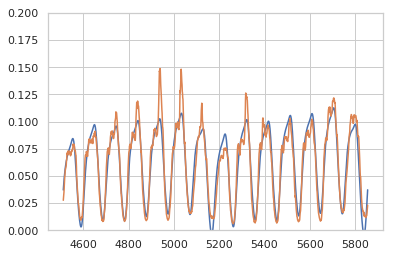

In [13]:
plt.plot(forecast['yhat'].iloc[-4*24*28:-4*24*14])
plt.plot(df_fb['y'].iloc[-4*24*14:])
plt.ylim(0, 0.2)

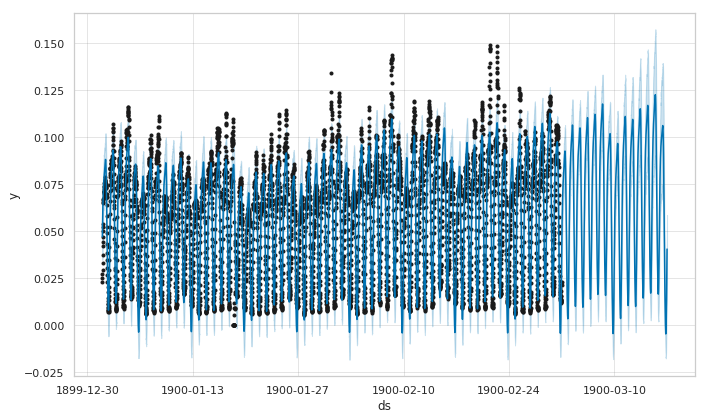

In [14]:
fig1 = m.plot(forecast)

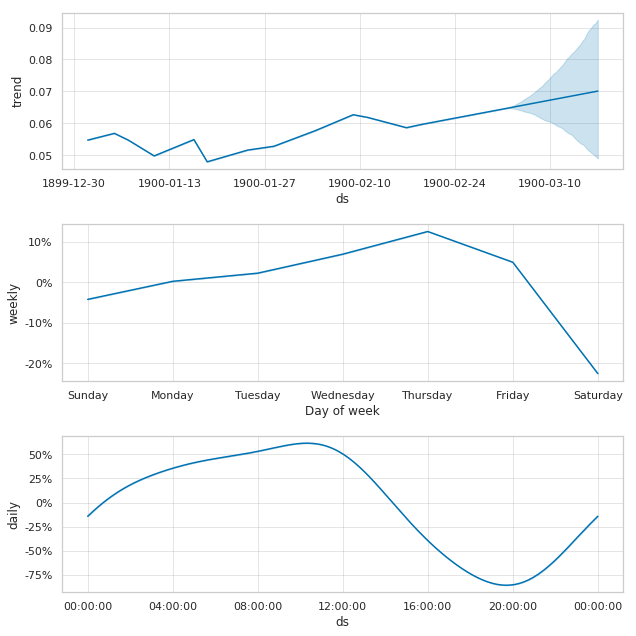

In [15]:
fig2 = m.plot_components(forecast)

### Test the accuracy of the model

#### Cross Validation

In [17]:
%%time
cv_results = cross_validation(m, initial='14 days', period='2.7 days', horizon='75 minutes')

INFO:fbprophet:Making 18 forecasts with cutoffs between 1900-01-16 00:54:00 and 1900-03-02 22:30:00


CPU times: user 1min 2s, sys: 83.4 ms, total: 1min 2s
Wall time: 1min 2s


In [18]:
perf = performance_metrics(cv_results)
perf.head()

,horizon,mse,rmse,mae,mape,coverage
0,00:09:00,0.000091,0.009551,0.007315,0.243989,0.888889
1,00:12:00,0.000073,0.008562,0.006316,0.220002,0.916667
2,00:15:00,0.000040,0.006288,0.005224,0.229806,1.000000
3,00:18:00,0.000039,0.006271,0.005514,0.174673,1.000000
4,00:21:00,0.000064,0.008025,0.006389,0.134761,0.888889


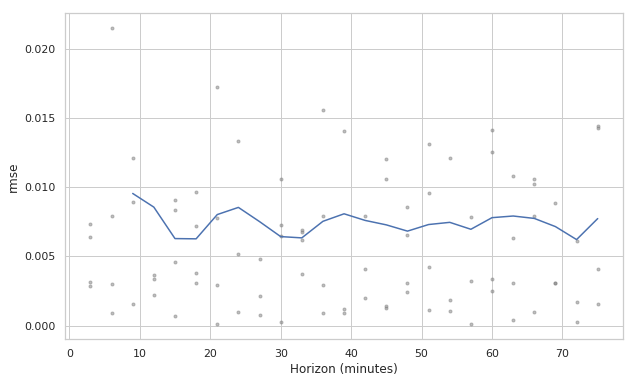

In [19]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

## Polynomial Regression (Global)

### Feature Engineering

Model performance with noncircular data:

- degree 1 polynomial regression loss: 0.03301799297801074
- degree 2 polynomial regression loss: 0.03290944631904917
- degree 3 polynomial regression loss: 0.03277589489257669
- degree 4 polynomial regression loss: 0.032357378781484
- degree 5 polynomial regression loss: 0.033557976697281486
- degree 6 polynomial regression loss: 0.033452838166617316

Model performance with circular data:

- degree 1 polynomial regression loss: 0.03479472885836981
- degree 2 polynomial regression loss: 0.03150584881539184
- degree 3 polynomial regression loss: 0.026258301575655837
- degree 4 polynomial regression loss: 0.02094351686131241
- degree 5 polynomial regression loss: 0.017019060758383636
- degree 6 polynomial regression loss: 0.01993239540174298

Model performance with circular data and StandardScaler

- degree 1 polynomial regression loss: 0.017139873933728997
- degree 2 polynomial regression loss: 0.01370629526366805
- degree 3 polynomial regression loss: 0.015275056003224334
- degree 4 polynomial regression loss: 0.05511846832290275
- degree 5 polynomial regression loss: 0.14277053161288725
- degree 6 polynomial regression loss: 0.2866760039535504

Model performance with circular data and Ridge Regressor

- degree 1 polynomial regression loss: 0.017141293664733485
- degree 2 polynomial regression loss: 0.0134805023548298
- degree 3 polynomial regression loss: 0.015738826632229398
- degree 4 polynomial regression loss: 0.05619655420357376
- degree 5 polynomial regression loss: 0.13911497385092336
- degree 6 polynomial regression loss: 0.29308150496173546

Model performance with circular data and BayesianRidge Regressor

- degree 1 polynomial regression loss: 0.01714250185459279
- degree 2 polynomial regression loss: 0.013480859686630958
- degree 3 polynomial regression loss: 0.015586556905475585
- degree 4 polynomial regression loss: 0.052803485210284544
- degree 5 polynomial regression loss: 0.10595560451391722
- degree 6 polynomial regression loss: 0.15703943537462886

In [20]:
# OPTION 1
df_poly = df.groupby(['day', 'weekday', 'hour', 'minutes'])["demand"].mean().reset_index()
df_poly.head()

,day,weekday,hour,minutes,demand
0,1,1,0,0,0.022744
1,1,1,0,15,0.025120
2,1,1,0,30,0.027232
3,1,1,0,45,0.029258
4,1,1,1,0,0.033303


In [26]:
# OPTION 2
df_poly = df.groupby(['day', 'weekday', 'hour', 'minutes',
                      'weekday_sin', 'weekday_cos',
                      'hour_sin', 'hour_cos',
                      'minutes_sin', 'minutes_cos'])["demand"].mean().reset_index()
df_poly = df_poly.drop(['weekday', 'hour', 'minutes'], axis=1)
df_poly.head()

,day,weekday_sin,weekday_cos,hour_sin,hour_cos,minutes_sin,minutes_cos,demand
0,1,0.781831,0.62349,0.000000,1.000000,0.000000e+00,1.000000e+00,0.022744
1,1,0.781831,0.62349,0.000000,1.000000,1.000000e+00,2.832769e-16,0.025120
2,1,0.781831,0.62349,0.000000,1.000000,5.665539e-16,-1.000000e+00,0.027232
3,1,0.781831,0.62349,0.000000,1.000000,-1.000000e+00,-1.836970e-16,0.029258
4,1,0.781831,0.62349,0.258819,0.965926,0.000000e+00,1.000000e+00,0.033303


In [ ]:
# OPTION 3
df_poly = df.groupby(['day', 'weekday', 'hour', 'minutes',
                      'lat', 'long',
                      'weekday_sin', 'weekday_cos',
                      'hour_sin', 'hour_cos',
                      'minutes_sin', 'minutes_cos'])["demand"].mean().reset_index()
df_poly = df_poly.drop(['weekday', 'hour', 'minutes'], axis=1)
df_poly.head()

In [ ]:
X_data = df_poly.drop('demand', axis=1)
y_data = df_poly['demand']

In [ ]:
TEST_TIMESTEPS = 5   # 4*24*14

X_train, X_test = X_data.loc[X_data["day"] < 61], X_data.loc[X_data["day"] >= 61]
y_train, y_test = y_data.loc[X_data["day"] < 61], y_data.loc[X_data["day"] >= 61]
#X_train, X_test = X_data.iloc[:-TEST_TIMESTEPS, :], X_data.iloc[-TEST_TIMESTEPS:, :]
#y_train, y_test = y_data.iloc[:-TEST_TIMESTEPS], y_data.iloc[-TEST_TIMESTEPS:]

In [29]:
X_test.head()

,day,weekday_sin,weekday_cos,hour_sin,hour_cos,minutes_sin,minutes_cos
5760,61,-0.974928,-0.222521,0.000000,1.000000,0.000000e+00,1.000000e+00
5761,61,-0.974928,-0.222521,0.000000,1.000000,1.000000e+00,2.832769e-16
5762,61,-0.974928,-0.222521,0.000000,1.000000,5.665539e-16,-1.000000e+00
5763,61,-0.974928,-0.222521,0.000000,1.000000,-1.000000e+00,-1.836970e-16
5764,61,-0.974928,-0.222521,0.258819,0.965926,0.000000e+00,1.000000e+00


In [30]:
y_test.head()

5760    0.045821
5761    0.047764
5762    0.049463
5763    0.051630
5764    0.054564
Name: demand, dtype: float64

### Train the Polynomial regressor

In [31]:
poly_regressors = [None]
for deg in range(1, 6+1):
  poly_reg = Pipeline([
    ('std_scaler', StandardScaler()),
    # ('norm', Normalizer()),
    # ('pca', PCA(n_components=0.90)),
    ('pol_features', PolynomialFeatures(degree=deg)),
    # ('lr', LinearRegression())
    ('lr', Ridge())
    # ('lr', Lasso())
    # ('lr', ElasticNet())
    # ('lr', BayesianRidge())
    # ('lr', ARDRegression())
  ])
  poly_reg = poly_reg.fit(X_train, y_train)
  poly_regressors.append(poly_reg)
  
  y_pred = poly_reg.predict(X_test)
  print("degree", deg, "polynomial regression loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

degree 1 polynomial regression loss: 0.012867159791181849
degree 2 polynomial regression loss: 0.010198660750270778
degree 3 polynomial regression loss: 0.012095784669649477
degree 4 polynomial regression loss: 0.015977331741434543
degree 5 polynomial regression loss: 0.010682098403046207
degree 6 polynomial regression loss: 0.04222795874871601


### Inspect the coefficients

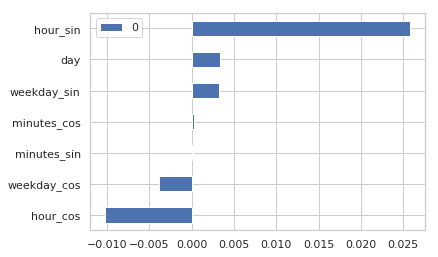

In [32]:
df_coefs = pd.DataFrame(np.expand_dims(poly_regressors[1]['lr'].coef_[1:], axis=0),
                        columns=X_train.columns).T
df_coefs.sort_values(by=0).plot.barh()

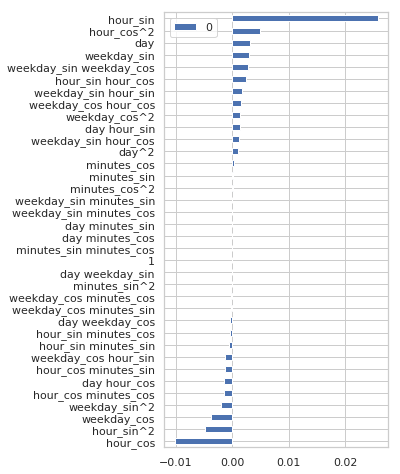

In [33]:
df_coefs = pd.DataFrame(np.expand_dims(poly_regressors[2]['lr'].coef_, axis=0),
                        columns=poly_regressors[2]['pol_features'].get_feature_names(X_train.columns)).T
df_coefs.sort_values(by=0).plot.barh(figsize=(4, 8))

### Predict using the polynomial regressor

(0, 0.2)

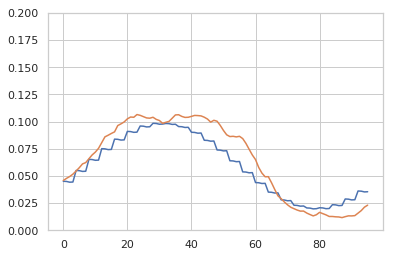

In [34]:
y_pred = poly_regressors[1].predict(X_test)

plt.plot(y_pred)
plt.plot(y_test.reset_index()['demand'])
plt.ylim(0, 0.2)

(0, 0.2)

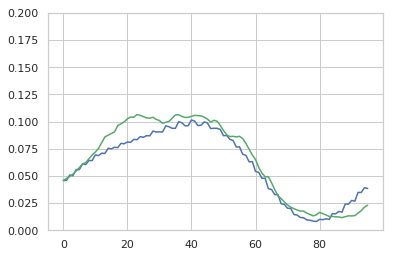

In [35]:
y_pred = poly_regressors[2].predict(X_test)

plt.plot(y_pred)
plt.plot(y_test.reset_index())
plt.ylim(0, 0.2)

(0, 0.2)

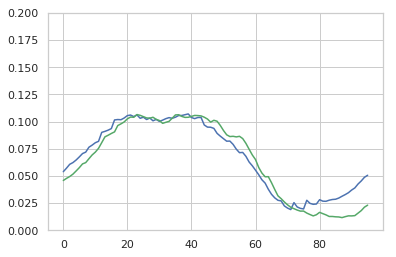

In [36]:
y_pred = poly_regressors[5].predict(X_test)

plt.plot(y_pred)
plt.plot(y_test.reset_index())
plt.ylim(0, 0.2)

## Random Forest

In [37]:
rfc = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1,
                            random_state=0, warm_start=False, verbose=1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=1,
                      warm_start=False)

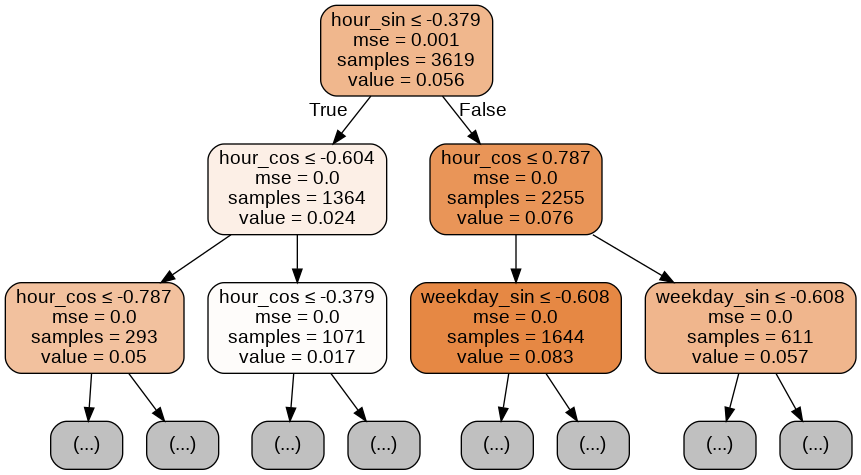

In [38]:
dot_data = StringIO()
export_graphviz(rfc.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_train.columns,
                max_depth=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [39]:
y_pred = rfc.predict(X_test)
print("Random Forest loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

Random Forest loss: 0.02206945313188081


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


(0, 0.2)

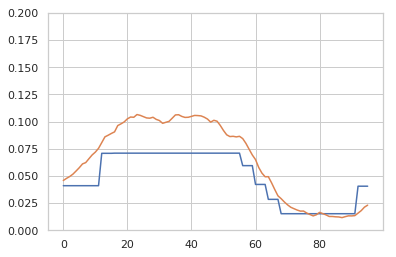

In [40]:
plt.plot(y_pred)
plt.plot(y_test.reset_index()['demand'])
plt.ylim(0, 0.2)

## XGBoost

In [41]:
xgb = XGBRegressor(random_state=0, n_jobs=-1, eval_metric='rmse')
xgb.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[07:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xgb.predict(X_test)
print("XGBoost loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost loss: 0.008056878994561456


(0, 0.2)

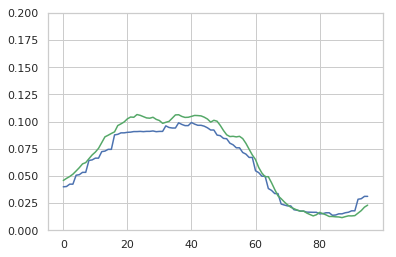

In [43]:
plt.plot(y_pred)
plt.plot(y_test.reset_index())
plt.ylim(0, 0.2)

## TPOT

In [44]:
tpot = TPOTRegressor(generations=10, 
                     population_size=20,
                     verbosity=2,
                     early_stop=3,
                     scoring='neg_mean_squared_error',
                     n_jobs=-1,
                     random_state=0,
                     warm_start=False,
                     subsample=1.0)
tpot.fit(X_train, y_train)

[07:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:58:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:59:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Generation 1 - Current best internal CV score: -0.00011797407808815296
[07:59:17] WARNING: /workspace/src/objec

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=3, generations=10,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=20,
              random_state=0, scoring='neg_mean_squared_error', subsample=1.0,
              template='RandomTree', use_dask=False, verbosity=2,
              warm_start=False)

In [45]:
y_pred = tpot.predict(X_test)
print("root_mean_squared_error:", math.sqrt(-tpot.score(X_test, y_test)))

root_mean_squared_error: 0.009172810740037117


(0, 0.2)

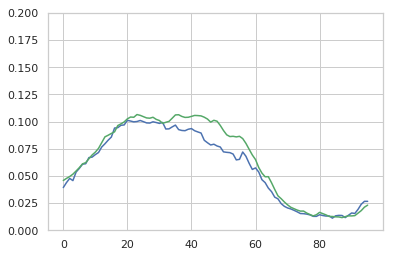

In [46]:
plt.plot(y_pred)
plt.plot(y_test.reset_index())
plt.ylim(0, 0.2)